In [89]:
# Import libraries that we'll need...
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import resample
import matplotlib
#from statsmodels.regression.linear_model import OLS
#from statsmodels.tools.tools import add_constant
#from statsmodels.nonparametric.smoothers_lowess import lowess

# new imports for polynomial regresion
#https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures


In [58]:
# Import data (I uploaded a copy to blackboard) and see what's in it
df_kidney = pd.read_csv('./kidney.csv')
df_kidney.head()

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30
4,21,0.98


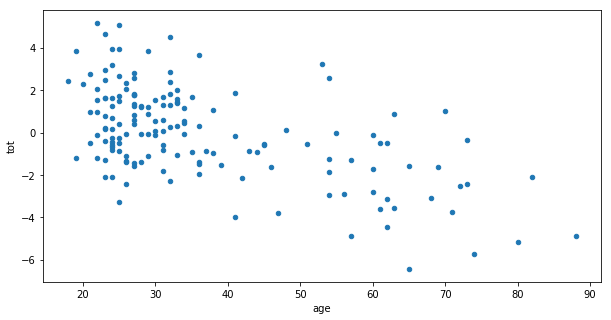

In [59]:
# As usual, plot the data...
df_kidney.plot(x='age', y='tot', kind='scatter', figsize=(10,5))

### linear fit

In [60]:
# Fit an Ordinary Least Squares (OLS) Regression estimator
#assign the dataframe columns to dependent/independent variables 
x = df_kidney['age']
X = sm.add_constant(x)
y= df_kidney['tot']
ols_reg_model = sm.OLS(y,X).fit()
#ols_reg_model.summary()

C:\Users\eider\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


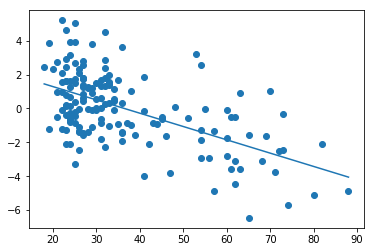

In [61]:
#create predictions on linear model
ypred = ols_reg_model.predict(X) 
plt.scatter(x,y)
plt.plot(x,ypred)


# Chapter 1 Exercises


## cubic fit

### a) - Fit a <b>cubic regression</b>, as a function of age, to the kidney data of Figures 1.1 and 1.2, calculating estimates and standard errors at ages 20, 30, 40, 50, 60, 70, 80 
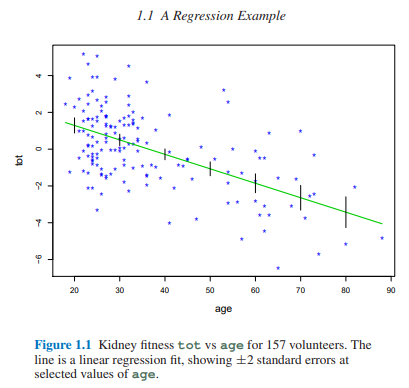

In [62]:
# intercep column
df_kidney["intercept"]=1
# compute the columns for age squared ans age cubed
df_kidney["age_sq"] = df_kidney["age"] ** 2
df_kidney["age_cu"] = df_kidney["age"] ** 3

In [63]:
#since the three predictor variables are on quite diferent sclaes we'll need to normalize
age_mean, age_std = df_kidney["age"].mean(), df_kidney["age"].std()
age_sq_mean, age_sq_std = df_kidney["age_sq"].mean(), df_kidney["age_sq"].std()
age_cu_mean, age_cu_std = df_kidney["age_cu"].mean(), df_kidney["age_cu"].std()


#not substract mean age from age var
df_kidney["age"] = (df_kidney["age"]) / age_std
df_kidney["age_sq"] = (df_kidney["age_sq"] - age_sq_mean) / age_sq_mean
df_kidney["age_cu"] = (df_kidney["age_cu"] - age_cu_mean) / age_cu_mean


In [64]:
# fit a OLS multiple regresion estimator
regressor_columns = ["intercept","age","age_sq","age_cu"]
ols_reg_model = sm.OLS(df_kidney["tot"],df_kidney[regressor_columns]).fit()
#ols_reg_model.summary()

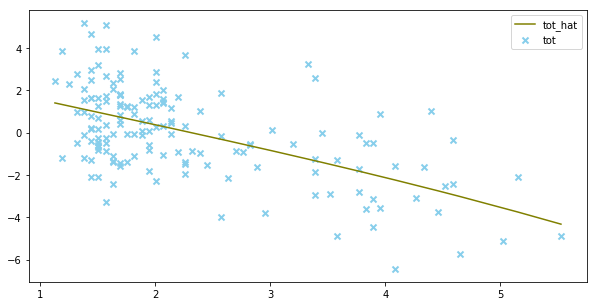

In [84]:
df_kidney["tot_hat"] = ols_reg_model.predict()
plt.figure(figsize=(10,5))
plt.scatter(df_kidney["age"],
            df_kidney["tot"],
            marker="x",
            color="skyblue",
            linewidth=2)

plt.plot(df_kidney["age"],df_kidney["tot_hat"],color="olive")
plt.legend()
plt.show()


In [65]:
#estimate error variance sigma^2 using (sum of squared errors)/ (n-p-1), where p=3 
#residuals are observed - predict
residuals = df_kidney["tot"] -ols_reg_model.predict() 
n= df_kidney.shape[0]
p = len(regressor_columns) -1
sigma_sq_hat = (residuals **2).sum() /(n-p-1)
sigma_sq_hat

3.284530610715059

In [66]:
#next we calculate (X'X)(-1) , where X is our matrix of predictors (age, age_sq, age_cu)
X_mat= np.array(df_kidney[regressor_columns])
#matmul = matrix multiplication of the transponse and X_mat(all the x variables)
X_sq_mat = np.matmul(np.transpose(X_mat), X_mat)
#the inverse of  X_sq_mat
X_sq_mat_inv = np.linalg.inv(X_sq_mat)
X_sq_mat_inv

array([[16.15122042, -7.06356109, 14.88281097, -4.9592784 ],
       [-7.06356109,  3.09039057, -6.51140382,  2.16974229],
       [14.88281097, -6.51140382, 14.01288456, -4.75969734],
       [-4.9592784 ,  2.16974229, -4.75969734,  1.64689942]])

In [67]:
#create a vetor with values for computing the standard errors at ages 20 to 80
selected_age_values =  np.reshape(np.linspace(20,80,7), (7,1) )

# create a testX_mat with the vector avobe 
test_X_mat = np.concatenate((np.reshape(np.repeat(1,(7)),(7,1)), selected_age_values), axis=1 )
test_X_mat[:,0]=1
test_X_mat[:,1] = test_X_mat[:,1]/ age_std
test_X_mat

array([[1.        , 1.25602923],
       [1.        , 1.88404385],
       [1.        , 2.51205847],
       [1.        , 3.14007309],
       [1.        , 3.7680877 ],
       [1.        , 4.39610232],
       [1.        , 5.02411694]])

In [68]:
if "age_sq" in regressor_columns:
    test_X_mat = np.concatenate((test_X_mat,selected_age_values**2),axis=1)
    test_X_mat[:,2] = (test_X_mat[:,2] - age_sq_mean) / age_sq_std
if "age_cu" in regressor_columns:
    test_X_mat = np.concatenate((test_X_mat,selected_age_values**3),axis=1)
    test_X_mat[:,3] = (test_X_mat[:,3] - age_cu_mean) / age_cu_std
    

In [69]:
#finally lets get the y_hat standard error for the requested values (seq(20,80))
n_test = selected_age_values.shape[0]
se_y_hat = np.zeros((n_test,1))



In [75]:
for i in range(n_test):
    se_y_hat[i] = np.sqrt(sigma_sq_hat * np.matmul(np.matmul(np.reshape(test_X_mat[i],
                                                                       (1,len(regressor_columns))),X_sq_mat_inv),
                                                  np.reshape(test_X_mat[i],(len(regressor_columns)))))
                          
y_hat =  ols_reg_model.predict(test_X_mat)                        

In [83]:

#the predicted values of the cubic regression
y_hat = y_hat.reshape(1,7)
#standard error of the predicted values
se_y_hat = se_y_hat.reshape(1,7)
#se_y_hat
table_result =np.concatenate((y_hat,se_y_hat),axis=1)
table_result.reshape(2,7)

array([[ 1.20366026,  0.47590424, -0.25160784, -0.98592385, -1.73409164,
        -2.50315906, -3.30017397],
       [ 0.74344986,  0.76777712,  0.34873207,  0.7037316 ,  1.89673973,
         3.31541289,  4.83020541]])

### b) - How do the results compare with those in Table 1.1?

attachment:image.png
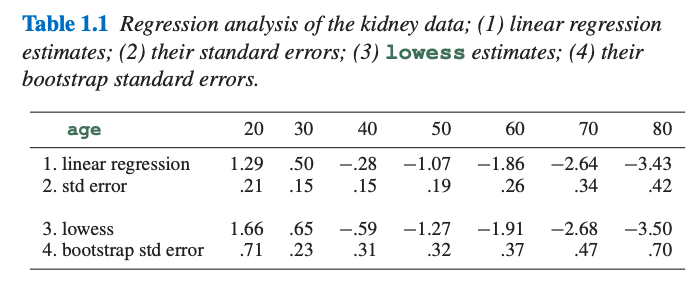


<span style="color:blue"><b> R:</b> compared to OLS univariate , the cubic regresion standard error seems worse even though the predicted values are very similar the reason behind that is that with the cubic regresion we have more degrees of freedom so we divide over a smaller number </span> 


### 2)   The lowess curve in Figure 1.2 has a flat spot between ages 25 and 35. Discuss how one might use bootstrap replications like those in Figure 1.3 to suggest whether the flat spot is genuine or just a statistical artifact.

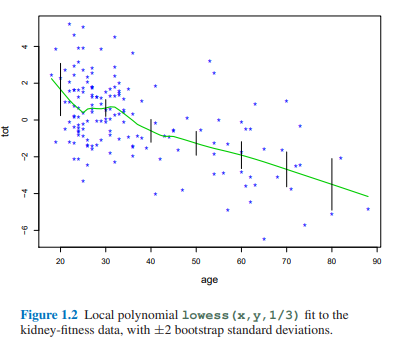


<span style="color:blue"><b> R:</b>  one way i can think of this,  
    
   
- is to boostrap sample only from observations from subjects with ages 25 to 35. 
- on each boostrap dataset i would compute linear regresion (using age and intercept).
- then i would collect the value of the coefficient for age on each bootstrap iteration (the slope).
- finally i would create a histogram with the values of age coefficients across boostrap samples and compute the confidence interval on the age coefficients using it, if the CI ranges from negative to positive values, then i would conclue the flat spot is legitimate.
    
  </span>  


### 3 Suppose that there were no differences between AML and ALL patients for any gene, so that t in (1.6) exactly followed a student-t distribution with 70 degrees of freedom in all 7128 cases. About how big might you expect the largest observed t value to be? Hint: 1/7128 = 0.00014.


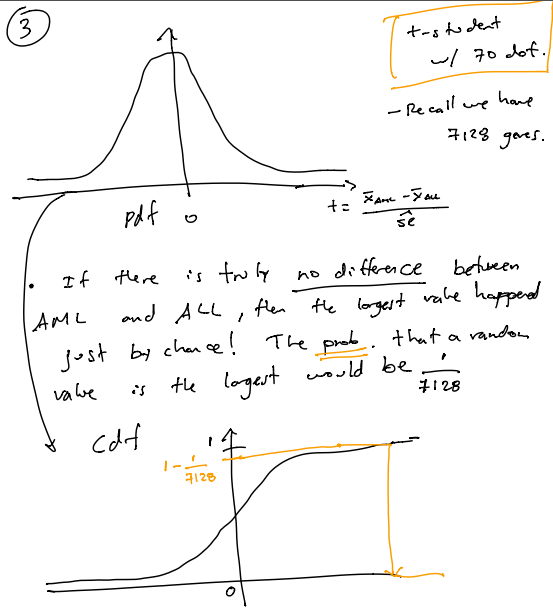

<span style="color:blue"><b> R:</b> look for the (1-1/7128) in the inverse cumulative denstity function (cdf) of a t70 distribution -> 3.826 </span>


# 4 
### a) Perform 1000 nonparametric bootstrap replications of ALL (1.5). (You can use program bcanon from the CRAN library “bootstrap” or type in the little program Algorithm 10.1 on page 178).





In [92]:
# Import data (I uploaded a copy to blackboard) and see what's in it
df_leuk = pd.read_csv('./leukemia_big.csv')
#df_leuk.head()
#work just with gene 136
df_leuk = df_leuk.iloc[135]
#
gene_136_df = pd.DataFrame(df_leuk.T).reset_index()
gene_136_df.columns = ["subject","gene_136_val"]
gene_136_df.head()

,subject,gene_136_val
0,ALL,0.918695
1,ALL.1,1.634002
2,ALL.2,0.459587
3,ALL.3,0.637966
4,ALL.4,0.344038


In [94]:
#number for all and aml
N_ALL = 47
N_AML = 25
#boostrap replications
B=1000
all_means = list()
aml_means = list()

for boostrap_ite in range(1,B+1):
    #just resample all/aml patients take its value and then calculate the mean
    resampled_ALL = resample(gene_136_df.loc[[("ALL" in elem) for elem in gene_136_df["subject"]], "gene_136_val"],n_samples=N_ALL)
    resampled_AML = resample(gene_136_df.loc[[("AML" in elem) for elem in gene_136_df["subject"]], "gene_136_val"],n_samples=N_AML)
    all_means.append(resampled_ALL.mean())
    aml_means.append(resampled_AML.mean())

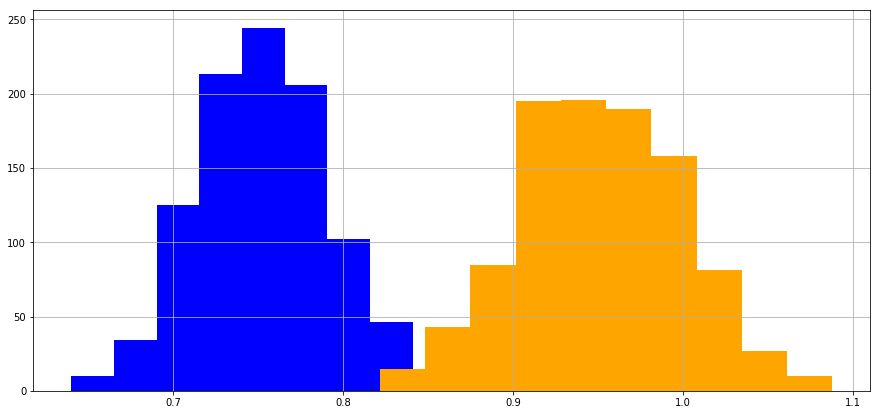

In [96]:
#create a dataframe of the 1000 means
means_df = pd.DataFrame({"all_means":all_means,"aml_means":aml_means})
#create a new feature with the differences of the mean
means_df["means_diff"]= means_df["aml_means"] - means_df["all_means"] 
ax = means_df["all_means"].hist(figsize=(15,7), color="b")
ax = means_df["aml_means"].hist(figsize=(15,7), color="orange",ax=ax)


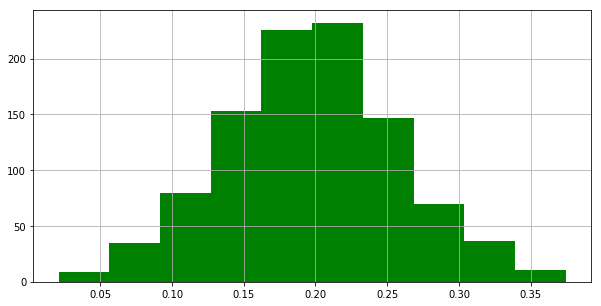

In [97]:
#now the histogram of the differences
means_df["means_diff"].hist(figsize=(10,5), color="green")

#as we can oberve there are not any value less than 0

In [101]:
#boostrap p-val of aml_mean being higher than all_mean is 0. thus, we're pretty sure
#number of times an observation in means diff is <0
all_big_than_aml = means_df[means_df["means_diff"] < 0].shape[0]

#empirical boostrap p-value 

all_big_than_aml / means_df.shape[0]




0.0